In [56]:
import networkx as nx
import pickle
import matplotlib.pyplot as plt
import random
from collections import defaultdict
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch_geometric.nn import GCNConv

ModuleNotFoundError: No module named 'torch'

In [7]:
# importing all following data and putting in a graph
pkl_file = open('Unfollower/15weeks_friend_dict.pkl', 'rb')
mydict2 = pickle.load(pkl_file)
pkl_file.close()

week = 0
for key, values in mydict2.items():
    if len(values[week]) == 0:
        mydict2[key] = []
        continue
    new = values[week][1]
    mydict2[key] = new

# mydict2 has format:
# user_id: [following_user_id1, following_user_id2...]

In [8]:
# forrest fire sampling implementation and use 
def forest_fire_sampling(graph_dict, initial_burn_probability, secondary_burn_probability, max_samples=None):
    # Choose a random start node
    random.seed(947)
    start_node = random.choice(list(graph_dict.keys()))
    
    # Force starting node to have at least 100 friends 
    if len(graph_dict[start_node]) < 100:
        start_node = random.choice(list(graph_dict.keys()))
    sampled_nodes = set([start_node])
    burning_nodes = set([start_node])
    
    while burning_nodes:
        new_burning_nodes = set()
        for node in burning_nodes:
            # For each neighbor, decide if it catches fire based on the burn probability
            for neighbor in graph_dict[node]:
                if neighbor not in sampled_nodes:
                    if random.random() < (initial_burn_probability if node == start_node else secondary_burn_probability):
                        new_burning_nodes.add(neighbor)
                        sampled_nodes.add(neighbor)
                        if max_samples and len(sampled_nodes) >= max_samples:
                            return sampled_nodes
        burning_nodes = new_burning_nodes

    return sampled_nodes

# sampling has undeterministic results where sample may have few nodes or many nodes depending on whether random starting node has many or few neighbors. We may want to force the starting node to have more than 10 friends. 

sample = forest_fire_sampling(mydict2, 0.2, 0.1, max_samples=1000)
shortened_dict = defaultdict(list)
print(len(mydict2))
for k in mydict2:
    if k in sample: 
        for v in mydict2[k]:
            if v in sample: 
                shortened_dict[k].append(v)

print(len(shortened_dict))

118640
970


1000


/Users/kevkoppa/anaconda3/lib/python3.11/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


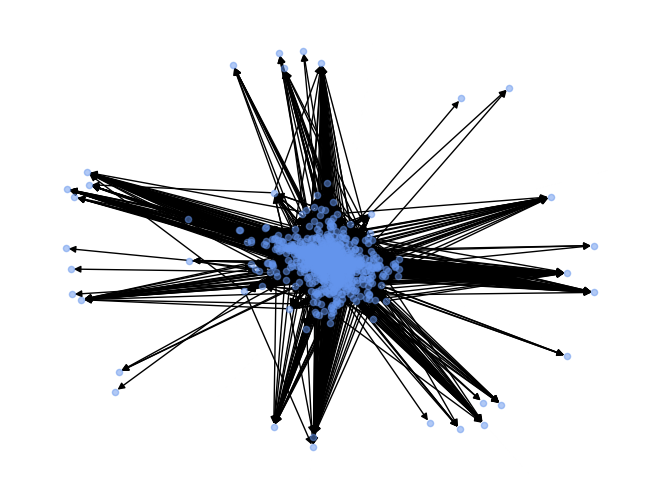

In [9]:
# Creating sample graph and drawing it 
subset_followers_graph = nx.DiGraph()
for k, v in shortened_dict.items():
    for neighbor in v:
        subset_followers_graph.add_edge(k, neighbor)

print(subset_followers_graph.number_of_nodes())

# Draw the graph node
nx.draw(subset_followers_graph, with_labels=False, node_size=20, node_color=(0.392, 0.584, 0.929, 0.5))

# Display the graph
plt.show()

In [11]:
removed_edges_graph = subset_followers_graph.copy()
print("edges before removal:",removed_edges_graph.number_of_edges())
def remove_edges(G, k):
    # Calculate the number of edges to remove (10% of total edges)
    num_edges_to_remove = int(k * G.number_of_edges())
    
    # Get the list of all edges in the graph
    all_edges = list(G.edges())
    random.seed(947)
    # Randomly select edges to remove
    removed_edges = random.sample(all_edges, num_edges_to_remove)
    
    # Remove the selected edges from the graph
    G.remove_edges_from(removed_edges)
    
    return set(removed_edges)

removed_edges = remove_edges(removed_edges_graph,0.1)
removed_nodes_set = set()
for edge in removed_edges:
    removed_nodes_set.add(edge[0])
print("edges after removal:", removed_edges_graph.number_of_edges())


edges before removal: 28423
edges after removal: 25581


In [55]:
edge_list = list(subset_followers_graph.edges)

# Simple GNN, might be better to test with multiple convolutional layers
class GNN(nn.Module):
    def __init__(self, num_nodes, embedding_dim=16):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(num_nodes, embedding_dim)
        self.conv2 = GCNConv(embedding_dim, 1)  # Output 1 for edge prediction

    def forward(self, edge_index):
        x = torch.ones((num_nodes, 1), dtype=torch.float32)  # Dummy node features
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x.squeeze(dim=1)

# Split the edge list into training and test sets
train_edge_list, test_edge_list = train_test_split(edge_list, test_size=0.15, random_state=42)

all_nodes = set(node for edge in edge_list for node in edge)
num_nodes = len(all_nodes)

model = GNN(num_nodes)

# The optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCEWithLogitsLoss()

# Training
num_epochs = 100
for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Adjacency matrix
    adjacency_matrix = torch.zeros((num_nodes, num_nodes), dtype=torch.float32)
    for edge in train_edge_list:
        adjacency_matrix[edge[0], edge[1]] = 1.0

    predictions = model(adjacency_matrix)

    targets = torch.zeros_like(predictions)
    for edge in train_edge_list:
        targets[edge[0], edge[1]] = 1.0

    loss = criterion(predictions, targets)

    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}")

model.eval()

# Adjacency matrix for the entire graph
adjacency_matrix_full = torch.zeros((num_nodes, num_nodes), dtype=torch.float32)
for edge in edge_list:
    adjacency_matrix_full[edge[0], edge[1]] = 1.0

# Predictions for the entire graph
predictions_full = model(adjacency_matrix_full)

# Evaluate on the test set
test_predictions = torch.zeros_like(predictions_full)
for edge in test_edge_list:
    test_predictions[edge[0], edge[1]] = 1.0

threshold = 0.5
binary_predictions = (predictions_full > threshold).int()

# Calculate accuracy on the test set
correct_predictions = (binary_predictions == test_predictions).sum().item()
total_predictions = test_predictions.sum().item()
accuracy = correct_predictions / total_predictions

print(f"Test Accuracy: {accuracy:.4f}")

NameError: name 'nn' is not defined

In [50]:
jaccard_coefficient_graph = removed_edges_graph.copy()

def jaccard_prediction(G, k):
    predictions = {}
    for node1 in removed_nodes_set:
        node1_friends = set(G.neighbors(node1))
        scores = []
        for node2 in list(G.nodes()):
            if node1==node2: continue
            if G.has_edge(node1, node2): continue
            node2_friends = set(G.neighbors(node2))
            total_friends = node1_friends.union(node2_friends)
            numerator = sorted(w for w in node1_friends if w in node2_friends)
            if len(total_friends)==0: score=0
            else: score = len(numerator)/len(total_friends)
            scores.append([node2, score])
        
        predicted_links = list(filter(lambda x: x[1] > k, scores))
        if len(predicted_links)>0:
            predictions[node1] = predicted_links
    
    predicted_edges = set()
    for node1,scores in predictions.items():
        for node2 in scores:
            predicted_edges.add((node1, node2[0]))
    return predicted_edges

# set of predicted edges via jaccard coefficient method: edge predicted as long as the score is above 0...
jaccard_predicted_edges = jaccard_prediction(removed_edges_graph,0.1)


In [54]:
print(len(jaccard_predicted_edges))
print(len(removed_edges))
def assess_accuracy(predicted_edges, actual_edges):
    actual_edge_set = set(actual_edges)
    predicted_edge_set = set(predicted_edges)
    
    # Calculate True Positive, False Positive, True Negative, False Negative
    true_positive = len(actual_edge_set.intersection(predicted_edge_set))
    false_positive = len(predicted_edge_set - actual_edge_set)
    false_negative = len(actual_edge_set - predicted_edge_set)
    
    # Calculate precision, recall, and f1 score
    
    # accuracy of positive predictions - if we predicted edge, is there actually edge?
    precision = true_positive / (true_positive + false_positive)
    
    # if there is edge, % of time we predict edge accurately?
    recall = true_positive / (true_positive + false_negative)
    
    # means of balancing
    if precision == 0 and recall == 0: f1_score = 0
    else: f1_score = 2 * (precision * recall) / (precision + recall)
    
    # Print the results
    print(f"Precision: {precision}", end=" ")
    print(f"Recall: {recall}", end = " ")
    print(f"F1 Score: {f1_score}", end = " ")

k = 0
while k < 1:
    jaccard_coefficient_graph_copy = removed_edges_graph.copy()
    jaccard_predicted_edges = jaccard_prediction(jaccard_coefficient_graph_copy, k)
    if len(jaccard_predicted_edges) == 0:
        break
    print(f"k={k}:")
    assess_accuracy(jaccard_predicted_edges, removed_edges)
    k += 0.1
    

0
2842
k=0:
Precision: 0.007993276683163695 Recall: 0.9035890218156228 F1 Score: 0.015846374092906155 k=0.1:
Precision: 0.038502262007892966 Recall: 0.422237860661506 F1 Score: 0.07056955511776296 k=0.2:
Precision: 0.10537751222161869 Recall: 0.13652357494722026 F1 Score: 0.11894543225015328 k=0.30000000000000004:
Precision: 0.21499013806706113 Recall: 0.038353272343420126 F1 Score: 0.06509405792773963 k=0.4:
Precision: 0.3181818181818182 Recall: 0.0049261083743842365 F1 Score: 0.009702009702009701 k=0.5:
Precision: 0.0 Recall: 0.0 F1 Score: 0 k=0.6:
Precision: 0.0 Recall: 0.0 F1 Score: 0 k=0.7:
Precision: 0.0 Recall: 0.0 F1 Score: 0 